TV-Regularized CT Reconstruction (Multiple Algorithms)
======================================================

This example demonstrates the use of different optimization algorithms to
solve the TV-regularized CT problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where $A$ is the X-ray transform (implemented using the SVMBIR
<cite data-cite="svmbir-2020"/> tomographic projection), $\mathbf{y}$ is the sinogram,
$C$ is a 2D finite difference operator, and $\mathbf{x}$ is the desired
image.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install 'scico[examples] @ git+https://github.com/lanl/scico'

import numpy as np

import matplotlib.pyplot as plt
import svmbir
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, metric, plot
from scico.linop import Diagonal
from scico.linop.xray.svmbir import SVMBIRSquaredL2Loss, XRayTransform
from scico.optimize import PDHG, LinearizedADMM
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Generate a ground truth image.

In [2]:
N = 256  # image size
density = 0.025  # attenuation density of the image
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.05, 0.02], gap=0.02, porosity=0.3), size=N - 10)
x_gt = x_gt / np.max(x_gt) * density
x_gt = np.pad(x_gt, 5)
x_gt[x_gt < 0] = 0

Generate tomographic projector and sinogram.

In [3]:
num_angles = int(N / 2)
num_channels = N
angles = snp.linspace(0, snp.pi, num_angles, endpoint=False, dtype=snp.float32)
A = XRayTransform(x_gt.shape, angles, num_channels)
sino = A @ x_gt

Impose Poisson noise on sinogram. Higher max_intensity means less noise.

In [4]:
max_intensity = 2000
expected_counts = max_intensity * np.exp(-sino)
noisy_counts = np.random.poisson(expected_counts).astype(np.float32)
noisy_counts[noisy_counts == 0] = 1  # deal with 0s
y = -snp.log(noisy_counts / max_intensity)

Reconstruct using default prior of SVMBIR <cite data-cite="svmbir-2020"/>.

In [5]:
weights = svmbir.calc_weights(y, weight_type="transmission")

x_mrf = svmbir.recon(
    np.array(y[:, np.newaxis]),
    np.array(angles),
    weights=weights[:, np.newaxis],
    num_rows=N,
    num_cols=N,
    positivity=True,
    verbose=0,
)[0]

Set up problem.

In [6]:
x0 = snp.array(x_mrf)
weights = snp.array(weights)
λ = 1e-1  # ℓ1 norm regularization parameter
f = SVMBIRSquaredL2Loss(y=y, A=A, W=Diagonal(weights), scale=0.5)
g = λ * functional.L21Norm()  # regularization functional
# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)

Solve via ADMM.

In [7]:
solve_admm = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[2e1],
    x0=x0,
    maxiter=50,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-4, "maxiter": 10}),
    itstat_options={"display": True, "period": 10},
)
print(f"Solving on {device_info()}\n")
print("ADMM:")
x_admm = solve_admm.solve()
hist_admm = solve_admm.itstat_object.history(transpose=True)
print(f"PSNR: {metric.psnr(x_gt, x_admm):.2f} dB\n")

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)

ADMM:


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  7.22e+00  8.953e+00  2.951e+00  1.133e+01     10  1.113e-03


  10  7.03e+01  1.610e+01  1.094e-01  6.111e-01      9  8.644e-05


  20  1.03e+02  1.621e+01  5.605e-02  2.334e-01      4  9.689e-05


  30  1.27e+02  1.625e+01  3.583e-02  2.540e-02      1  9.975e-05


  40  1.46e+02  1.627e+01  2.638e-02  4.902e-02      2  8.327e-05


  49  1.61e+02  1.628e+01  2.297e-02  6.018e-02      2  9.095e-05


PSNR: 23.05 dB



Solve via Linearized ADMM.

In [8]:
solver_ladmm = LinearizedADMM(
    f=f,
    g=g,
    C=C,
    mu=3e-2,
    nu=2e-1,
    x0=x0,
    maxiter=50,
    itstat_options={"display": True, "period": 10},
)
print("Linearized ADMM:")
x_ladmm = solver_ladmm.solve()
hist_ladmm = solver_ladmm.itstat_object.history(transpose=True)
print(f"PSNR: {metric.psnr(x_gt, x_ladmm):.2f} dB\n")

Linearized ADMM:


Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  1.53e+00  5.311e+00  1.073e+00  1.101e+00


  10  8.22e+00  1.540e+01  1.336e-01  5.304e-02


  20  1.44e+01  1.586e+01  5.624e-02  2.243e-02


  30  2.08e+01  1.599e+01  3.315e-02  1.138e-02


  40  2.64e+01  1.607e+01  2.355e-02  6.661e-03


  49  3.12e+01  1.612e+01  1.894e-02  4.355e-03
PSNR: 22.96 dB



Solve via PDHG.

In [9]:
solver_pdhg = PDHG(
    f=f,
    g=g,
    C=C,
    tau=2e-2,
    sigma=8e0,
    x0=x0,
    maxiter=50,
    itstat_options={"display": True, "period": 10},
)
print("PDHG:")
x_pdhg = solver_pdhg.solve()
hist_pdhg = solver_pdhg.itstat_object.history(transpose=True)
print(f"PSNR: {metric.psnr(x_gt, x_pdhg):.2f} dB\n")

PDHG:


Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  6.37e-01  2.255e+01  7.299e+00  1.061e+00


  10  6.84e+00  1.756e+01  1.805e+00  9.469e-02


  20  1.24e+01  1.681e+01  6.777e-01  3.966e-02


  30  1.78e+01  1.655e+01  2.911e-01  2.206e-02


  40  2.33e+01  1.646e+01  1.501e-01  1.493e-02


  49  2.79e+01  1.642e+01  9.095e-02  1.176e-02
PSNR: 23.03 dB



Show the recovered images.

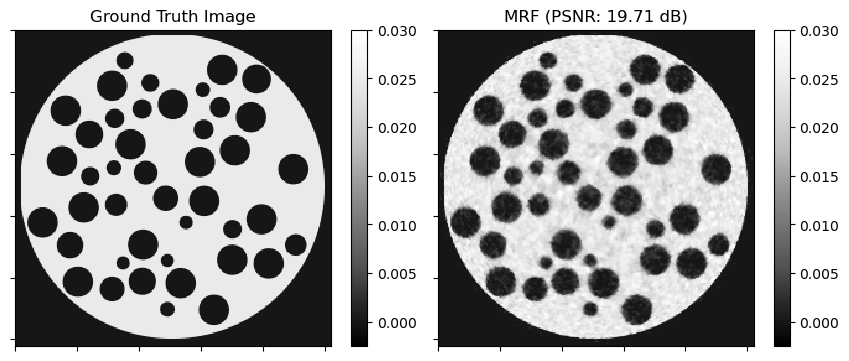

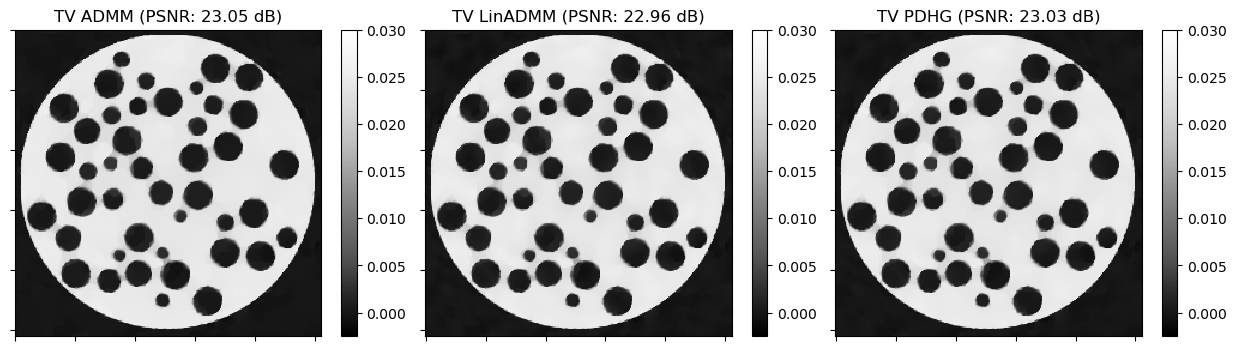

In [10]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1 * density, vmax=1.2 * density)
fig, ax = plt.subplots(1, 2, figsize=[10, 5])
plot.imview(img=x_gt, title="Ground Truth Image", cbar=True, fig=fig, ax=ax[0], norm=norm)
plot.imview(
    img=x_mrf,
    title=f"MRF (PSNR: {metric.psnr(x_gt, x_mrf):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1],
    norm=norm,
)
fig.show()

fig, ax = plt.subplots(1, 3, figsize=[15, 5])
plot.imview(
    img=x_admm,
    title=f"TV ADMM (PSNR: {metric.psnr(x_gt, x_admm):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[0],
    norm=norm,
)
plot.imview(
    img=x_ladmm,
    title=f"TV LinADMM (PSNR: {metric.psnr(x_gt, x_ladmm):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1],
    norm=norm,
)
plot.imview(
    img=x_pdhg,
    title=f"TV PDHG (PSNR: {metric.psnr(x_gt, x_pdhg):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[2],
    norm=norm,
)
fig.show()

Plot convergence statistics.

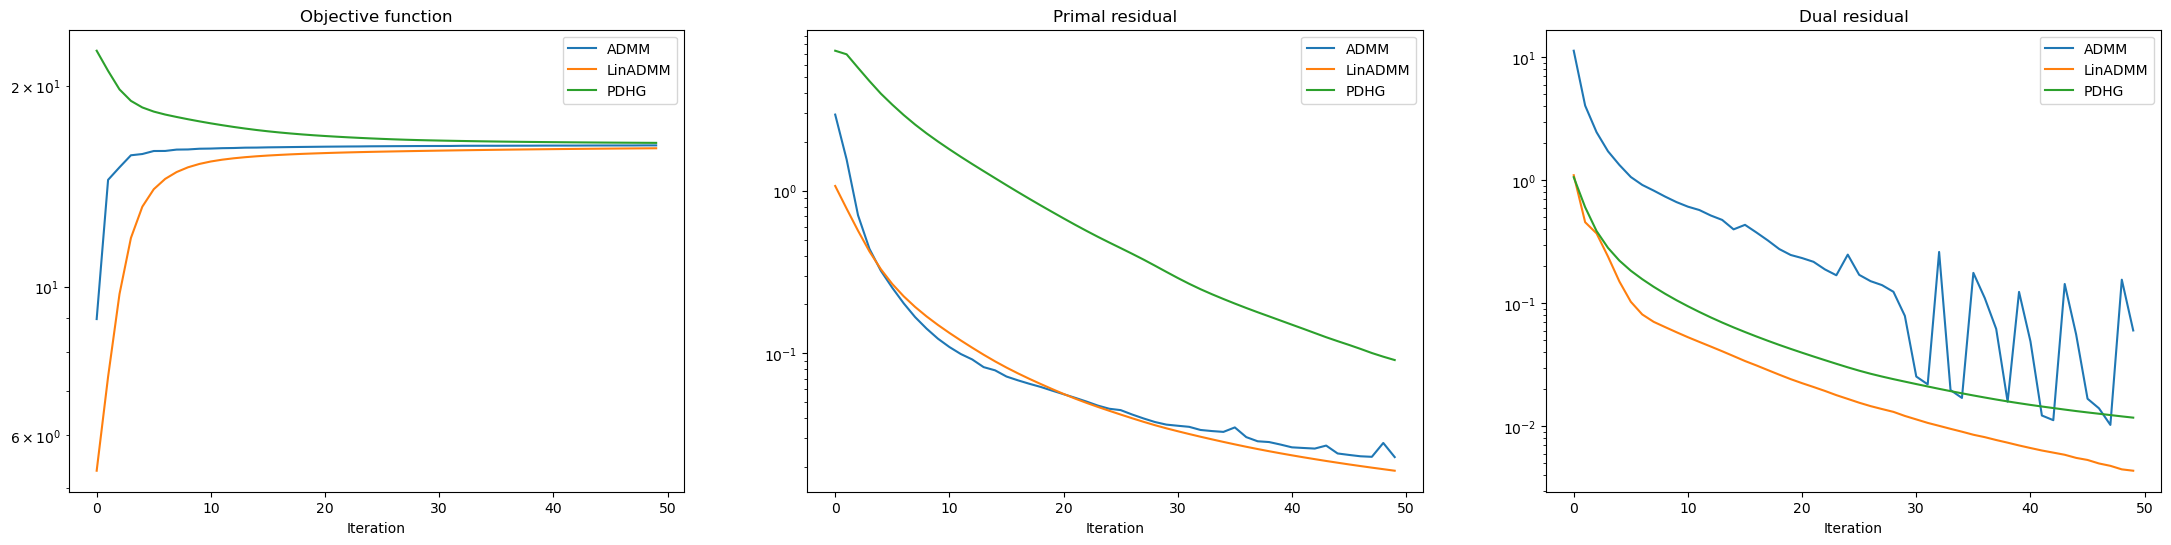

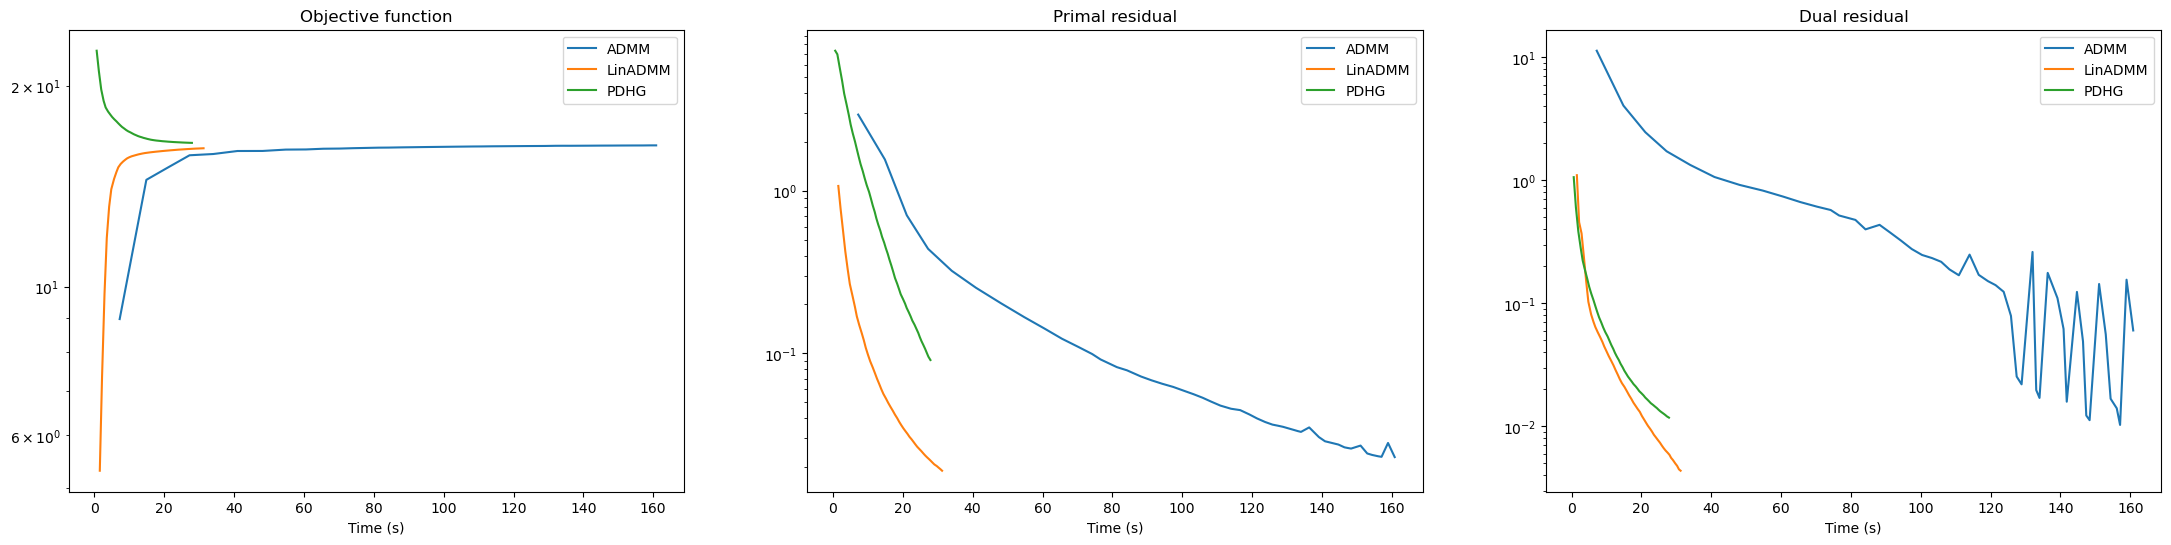

In [11]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()

fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()